In [ ]:
# Mount google drive where the dataset was uploaded
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and Import required packages and libraries
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download(['stopwords',
               'punkt',
               'wordnet',
               'omw-1.4',
               'vader_lexicon'
               ])
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import bigrams, trigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Change files extension in dataset subdirectories to .xml
- the downloaded dataset has no extension
- the function change_extensions_in_directory assigns a directory to the each file in each subdirectory with a '.xml' file extension

In [ ]:
# Directory containing subdirectories with files
base_folder = "drive/MyDrive/cars/"
new_extension = ".xml"

# Function to change file extensions in a directory
def change_extensions_in_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if os.path.isfile(file_path):
            file_name, old_extension = os.path.splitext(filename)
            new_file_path = os.path.join(directory, file_name + new_extension)
            shutil.move(file_path, new_file_path)

# Iterate through subdirectories in the base folder
for root, dirs, files in os.walk(base_folder):
    for subdirectory in dirs:
        subdirectory_path = os.path.join(root, subdirectory)
        change_extensions_in_directory(subdirectory_path)

print("File extensions have been changed to .xml in all subdirectories.")


File extensions have been changed to .xml in all subdirectories.


## Data Importing Function
- Import the data from each '.xml' file available in the 2007, 2008, and 2009 subdirectories.
- function process_file() extracts the data from the '.xml' files and store in a dataframe.

In [ ]:
# Base directory containing subdirectories with XML files
base_folder = "drive/MyDrive/cars/"

# list to store extracted data
data_list = []

In [ ]:
# Function to extract data from each XML file
def process_file(file_path):
    car_name = None
    car_model = None
    date = None
    author = None
    comment = None
    favorite = None

    with open(file_path, 'rb') as file:
        in_doc = False
        for line in file:
            line = line.decode('utf-8', errors='ignore')
            if line.strip().startswith("<DOCNO>"):
                car_detail = line.strip().replace("<DOCNO>", "").replace("</DOCNO>", "")
                # Remove the ".xml" extension
                car_model_and_name = car_detail.split('.xml')[0]
                # Split the string by underscore
                split_by_underscore = car_model_and_name.split('_')
                car_model = split_by_underscore[0]
                car_name = " ".join(split_by_underscore[1:])
            elif line.strip() == "<DOC>":
                in_doc = True
                comment = ""
            elif line.strip() == "</DOC>":
                in_doc = False
                data_list.append([car_name, car_model, date, author, comment, favorite])
            elif in_doc:
                # capture comments on 2008_honda_accord.xml
                comment += line
                if line.strip().startswith("<DATE>"):
                    date = line.strip().replace("<DATE>", "").replace("</DATE>", "")
                elif line.strip().startswith("<AUTHOR>"):
                    author = line.strip().replace("<AUTHOR>", "").replace("</AUTHOR>", "")
                elif line.strip().startswith("<TEXT>"):
                    # capture comment on every other file
                    comment = line.strip().replace("<TEXT>", "").replace("</TEXT>", "")
                elif line.strip().startswith("<FAVORITE>"):
                    favorite = line.strip().replace("<FAVORITE>", "").replace("</FAVORITE>", "")

In [ ]:
# Iterate through subdirectories in the base folder
for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".xml"):
            file_path = os.path.join(root, file)
            process_file(file_path)

# Create a Pandas DataFrame
cars_df = pd.DataFrame(data_list, columns=['Car_Name', 'Car_Model', 'Date', 'Author', 'Comment', 'Favorite'])

# Print the DataFrame
cars_df.head()

,Car_Name,Car_Model,Date,Author,Comment,Favorite
0,bmw x5,2008,05/12/2009,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...
1,bmw x5,2008,04/22/2009,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...
2,bmw x5,2008,04/13/2009,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera
3,bmw x5,2008,04/02/2009,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...
4,bmw x5,2008,03/27/2009,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ..."


In [ ]:
# checking the last row of the data
cars_df.tail()

,Car_Name,Car_Model,Date,Author,Comment,Favorite
42283,toyota camry hybrid,2007,04/30/2007,exrep,Traded my 2004 Prius with 68000 trouble free m...,Navigation system.
42284,toyota camry hybrid,2007,04/27/2007,Toyo Camry Hybrid,"I have never been a toyota fan, but this car i...","Fuel economy, high quality leather, technology..."
42285,toyota camry hybrid,2007,04/20/2007,rae,We had to wait 4 months before picking up the ...,Very practical car and very modern technology ...
42286,toyota camry hybrid,2007,04/20/2007,Stewn,"Through 11 months and 16,500 miles the Camry H...","CVT transmission,"
42287,toyota camry hybrid,2007,04/16/2007,Luis,It feels as though you're driving in a cloud. ...,I enjoy the comfort and the smoothe interior d...


In [ ]:
# Getting the number of instances for each feature in the dataset
cars_df.count()

Car_Name     42288
Car_Model    42288
Date         41748
Author       41748
Comment      42288
Favorite     41748
dtype: int64

In [ ]:
# Getting a summary of the dataset
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42288 entries, 0 to 42287
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Car_Name   42288 non-null  object
 1   Car_Model  42288 non-null  object
 2   Date       41748 non-null  object
 3   Author     41748 non-null  object
 4   Comment    42288 non-null  object
 5   Favorite   41748 non-null  object
dtypes: object(6)
memory usage: 1.9+ MB


In [ ]:
# Checking for null values
cars_df.isnull().sum()

Car_Name       0
Car_Model      0
Date         540
Author       540
Comment        0
Favorite     540
dtype: int64

In [ ]:
# Exploring one of the columns with null values
cars_df[cars_df['Author'].isnull()].head()

,Car_Name,Car_Model,Date,Author,Comment,Favorite
14898,honda accord,2008,None,None,\r\n\r\nJust turned 90K and still pleased. 2nd...,None
14899,honda accord,2008,None,None,\r\n\r\nI've owned three vehicles prior to my ...,None
14900,honda accord,2008,None,None,\r\n\r\nPurchased a Honda Accord V6 due to the...,None
14901,honda accord,2008,None,None,\r\n\r\nI leased a 2008 Accord in April 2008 -...,None
14902,honda accord,2008,None,None,\r\n\r\nOverall a pretty nice car but has some...,None


In [ ]:
# Getting the number of data availabe on each Car model year available
cars_df.groupby(cars_df.Car_Model).count()

,Car_Name,Date,Author,Comment,Favorite
Car_Model,,,,,
2007,18903,18903,18903,18903,18903
2008,15438,14898,14898,15438,14898
2009,7947,7947,7947,7947,7947


## Data Preprocessing:
- Text Cleaning:
- Lowercase the text.
- Remove non-alphanumeric characters.
- Tokenize the text.
- Remove stop words.
- Lemmatize words.

In [ ]:
# Function for text preprocessing
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Lowercase the text
    text = text.lower()

    # Remove non-alphanumeric characters
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])

    # Tokenization and lemmatization
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

    # Join tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply the preprocessing to the 'Comment' column
cars_df['Processed_Comment'] = cars_df['Comment'].apply(preprocess_text)

In [ ]:
# check the update on the cars_df
cars_df.head()

,Car_Name,Car_Model,Date,Author,Comment,Favorite,Processed_Comment
0,bmw x5,2008,05/12/2009,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,great car performance sport package exceptiona...
1,bmw x5,2008,04/22/2009,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,since bought ive enjoyed everyday ride tight l...
2,bmw x5,2008,04/13/2009,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,bought brand new june two month later motor ac...
3,bmw x5,2008,04/02/2009,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,ill make blunt car year put mile overall nice ...
4,bmw x5,2008,03/27/2009,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",bought year ago tomorrow taking dealership tim...


In [ ]:
def plot_ngrams(df_column, n, title):
    # Tokenize the comments
    tokens = nltk.word_tokenize(" ".join(df_column))

    # Create n-grams
    n_grams = list(nltk.ngrams(tokens, n))

    # Calculate frequency distribution of n-grams
    freq_dist = FreqDist(n_grams)

    # Extract n-gram labels and counts
    ngram_labels, ngram_counts = zip(*freq_dist.most_common(30))

    # Unpack n-gram labels for plotting
    ngram_labels = [' '.join(ngram) for ngram in ngram_labels]

    # Plotting
    plt.barh(ngram_labels, ngram_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')
    plt.title(f'{title} - {n}-grams')
    plt.gca().invert_yaxis()

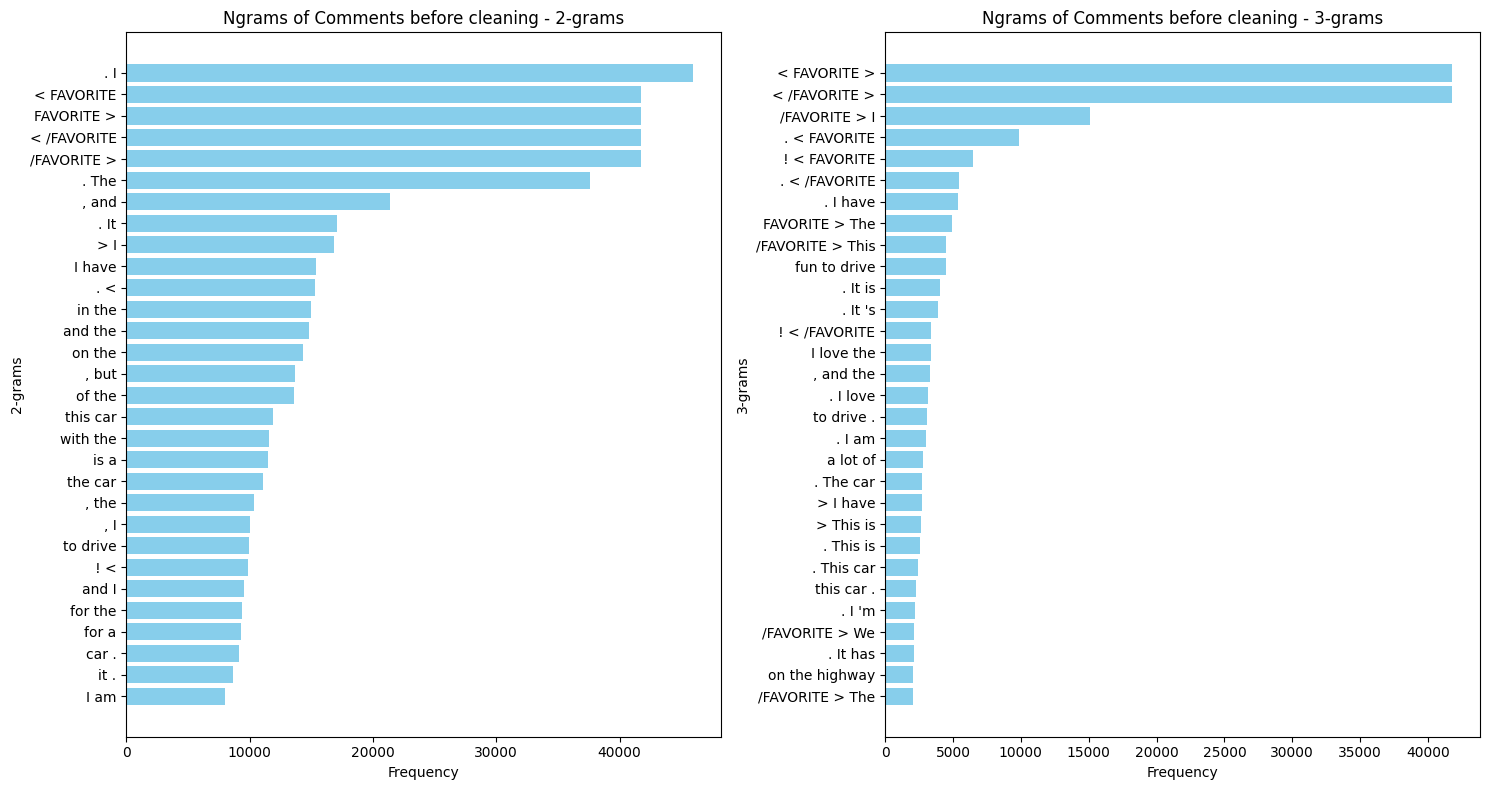

In [ ]:
# specify fig size
plt.figure(figsize=(15, 8))

# Plot Bigrams
plt.subplot(1, 2, 1)
plot_ngrams(cars_df['Comment'], 2, 'Ngrams of Comments before cleaning')

# Plot Trigrams
plt.subplot(1, 2, 2)
plot_ngrams(cars_df['Comment'], 3, 'Ngrams of Comments before cleaning')

plt.tight_layout()
plt.show()


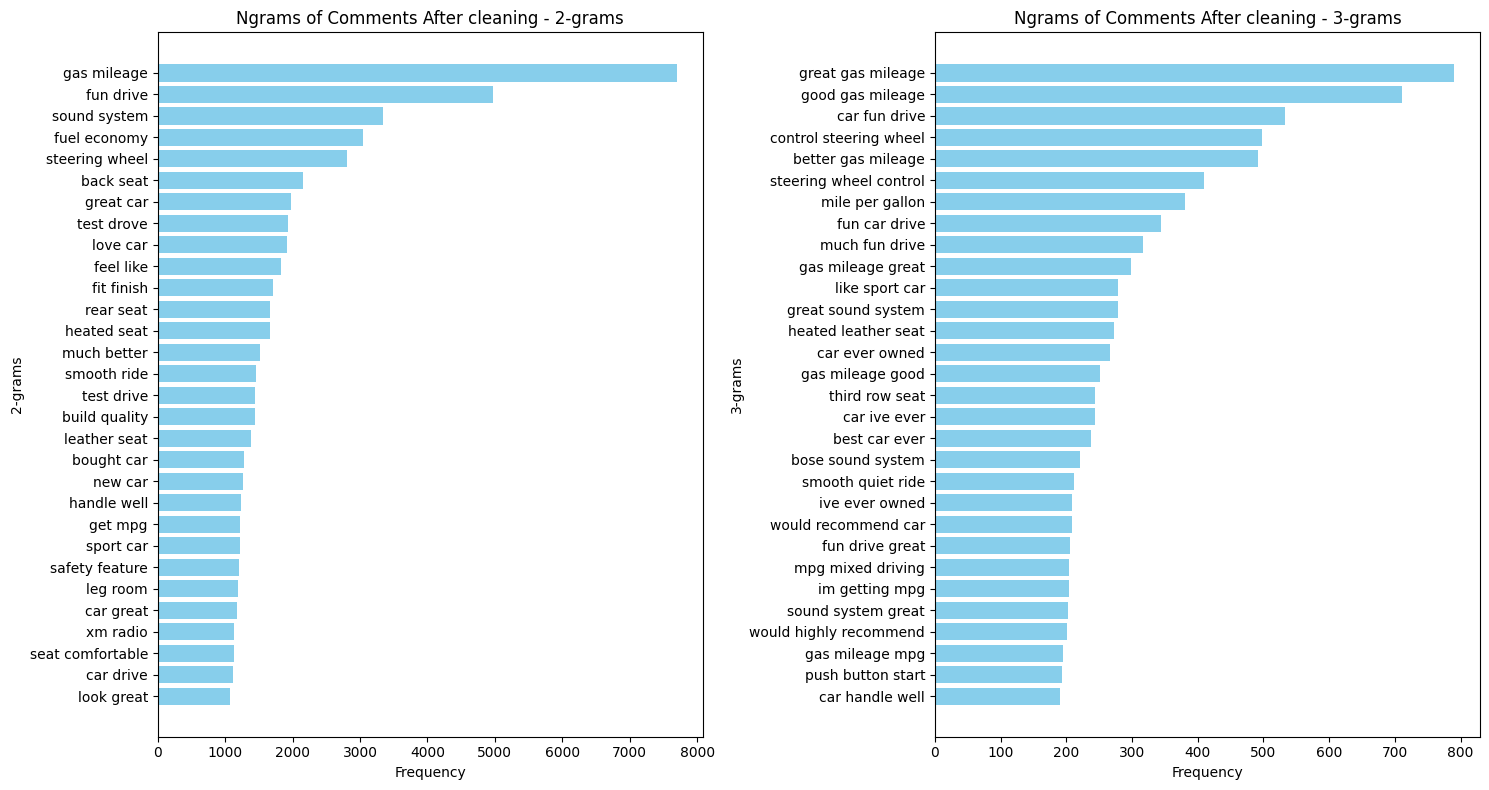

In [ ]:
# specify fig size
plt.figure(figsize=(15, 8))

# Plot Bigrams
plt.subplot(1, 2, 1)
plot_ngrams(cars_df['Processed_Comment'], 2, 'Ngrams of Comments After cleaning')

# Plot Trigrams
plt.subplot(1, 2, 2)
plot_ngrams(cars_df['Processed_Comment'], 3, 'Ngrams of Comments After cleaning')

plt.tight_layout()
plt.show()


## Sentiment Analysis:
- Perform sentiment analysis on the processed comment
- classify the comment as Positive or Nagative based on sentiment
- Calculate the sentiment score for the comment

In [ ]:
# Define the sentiment threshold values
threshold = 0.0

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores and ratings using lambda function
cars_df['Sentiment'] = cars_df['Processed_Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
cars_df['rating'] = cars_df['Sentiment'].apply(lambda score: 'Negative' if score <= threshold else 'Positive')

# Display the first 10 rows of the DataFrame
cars_df.head(10)

,Car_Name,Car_Model,Date,Author,Comment,Favorite,Processed_Comment,Sentiment,rating
0,bmw x5,2008,05/12/2009,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,great car performance sport package exceptiona...,0.8910,Positive
1,bmw x5,2008,04/22/2009,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,since bought ive enjoyed everyday ride tight l...,0.9916,Positive
2,bmw x5,2008,04/13/2009,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,bought brand new june two month later motor ac...,-0.9432,Negative
3,bmw x5,2008,04/02/2009,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,ill make blunt car year put mile overall nice ...,0.9780,Positive
4,bmw x5,2008,03/27/2009,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",bought year ago tomorrow taking dealership tim...,-0.7650,Negative
5,bmw x5,2008,02/12/2009,2008 BMW X5,This SUV handles like truck and rides like tru...,Exterior design only,suv handle like truck ride like truck regular ...,-0.6597,Negative
6,bmw x5,2008,02/04/2009,Patrick,Great driving. Sun visors are not very useful....,Adaptive headlights and voice command controls.,great driving sun visor useful running board n...,0.8360,Positive
7,bmw x5,2008,01/24/2009,Chuck,"Transmission shift points unpredictable, hangs...",Power and looks.,transmission shift point unpredictable hang lo...,-0.8074,Negative
8,bmw x5,2008,01/14/2009,mattshahidi,At first the X5 was great to drive until all t...,"Looks are nice, interior and gadgets are what ...",first great drive problem started know history...,-0.9231,Negative
9,bmw x5,2008,01/14/2009,AbaundvrM3,"Overall my wife and I love the X5, its classy,...","Power lift tailgate, sure footed in slippery c...",overall wife love classy ride good get decent ...,0.8941,Positive


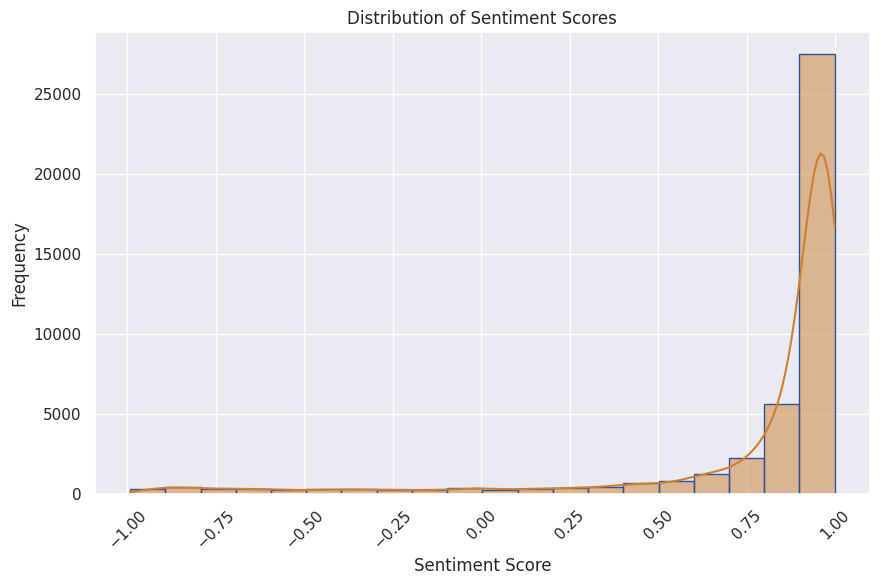

In [ ]:
# Set the style for the plot
sns.set(style="darkgrid")

# Specify the figure size
plt.figure(figsize=(10, 6))

# Create a histogram plot with seaborn
sns.histplot(cars_df['Sentiment'], bins=20, kde=True, color='#CD7F32', edgecolor='#2F539B')

# Customize the plot
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

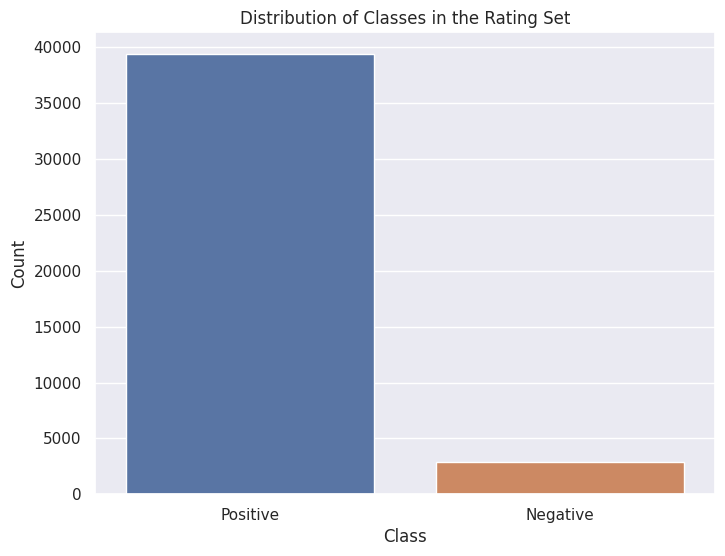

In [ ]:
# Set the plot style
sns.set_style("darkgrid")

plt.figure(figsize=(8, 6))
sns.countplot(data=cars_df, x='rating')
plt.title('Distribution of Classes in the Rating Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show();

## Machine Learning Model Development
Develop a machine learning model to classify the comment into as either Positive or Negative
- Split dataset into training and test set
- Apply TF-IDF Vectorizer on the dataset for encoding
- Balance the dataset using SMOTE
- Train the Multinomial Naive Bayes classifier model on the balanced Dataset
- Evaluate the model
- Develop a function to predict the sentiment (positive or negative) from unprocessed comment

In [ ]:
# Create a new DataFrame with the Processed_Comment and rating for ML model training
df_classification = cars_df[['Processed_Comment', 'rating']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_classification['Processed_Comment'],
    df_classification['rating'],
    test_size=0.2,
    random_state=42
)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

In [ ]:
# Use SMOTE to oversample the minority class (Negative comments)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

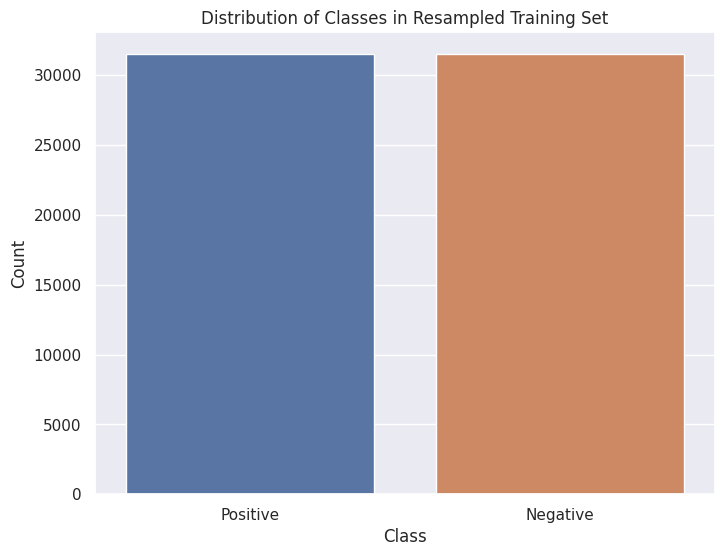

In [ ]:
# Set the plot style
sns.set_style("darkgrid")

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribution of Classes in Resampled Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show();

In [ ]:
# Initialize the Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Train the classifier on the resampled data
clf.fit(X_train_resampled, y_train_resampled)

# Transform the testing data
X_test_vectorized = vectorizer.transform(X_test)

# Predictions
y_preds = clf.predict(X_test_vectorized)

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))
print("\nClassification Report:\n", classification_report(y_test, y_preds))

Accuracy: 0.9093166233152046

Classification Report:
               precision    recall  f1-score   support

    Negative       0.41      0.72      0.52       586
    Positive       0.98      0.92      0.95      7872

    accuracy                           0.91      8458
   macro avg       0.69      0.82      0.74      8458
weighted avg       0.94      0.91      0.92      8458



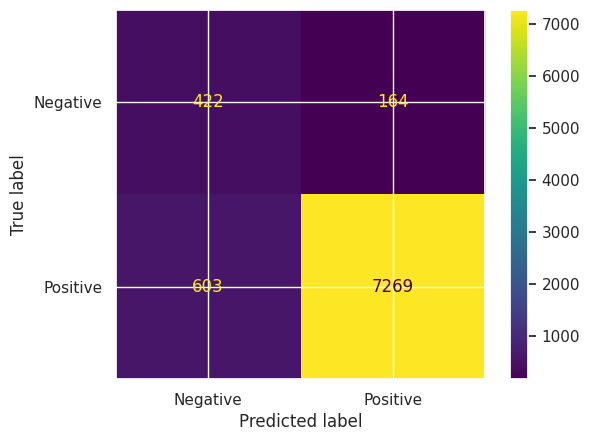

In [ ]:
# print confusion metrix from predictions
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_preds);

## Classify Sentiment of Raw Comments

In [ ]:
# Save the trained model and vectorizer
joblib.dump(clf, 'multinomial_nb_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

def classify_sentiment(raw_comment):
    # Preprocess the raw comment
    processed_comment = preprocess_text(raw_comment)

    # Transform the processed comment using the vectorizer
    comment_vectorized = vectorizer.transform([processed_comment])

    # Predict sentiment using the MultinomialNB model
    prediction = clf.predict(comment_vectorized)

    # Return the predicted sentiment ('Negative' or 'Positive')
    return prediction[0]

In [ ]:
# Applying the classify_sentiment function on a unprocessed comment
raw_comment = cars_df['Comment'][9]
result = classify_sentiment(raw_comment)
print(f"The sentiment of the comment is: {result}")

The sentiment of the comment is: Positive


## Identify Top Three Cars with Positive Reviews:

In [ ]:
# Identify Top Three Cars model with highest Positive Reviews
top_Model = cars_df.groupby(['Car_Model'])['Sentiment'].mean().sort_values(ascending=False).head(3)
print("Top 3 Cars Based on Average Sentiment:")
print(top_Model)

Top 3 Cars Based on Average Sentiment:
Car_Model
2009    0.809739
2008    0.790991
2007    0.775621
Name: Sentiment, dtype: float64


In [ ]:
# Identify Top Three Cars with highest Positive Reviews
top_cars = cars_df.groupby(['Car_Name'])['Sentiment'].mean().sort_values(ascending=False).head(3)
top_rated_cars_model = cars_df.groupby(['Car_Name', 'Car_Model'])['Sentiment'].mean().sort_values(ascending=False).head(3)
print("Top 3 Cars Based on Average Sentiment:")
print(top_rated_cars_model)

Top 3 Cars Based on Average Sentiment:
Car_Name      Car_Model
volvo s40     2008         0.966284
infiniti m45  2008         0.953473
bmw x6        2009         0.949208
Name: Sentiment, dtype: float64


## WordClouds for Positive Reviews by Car

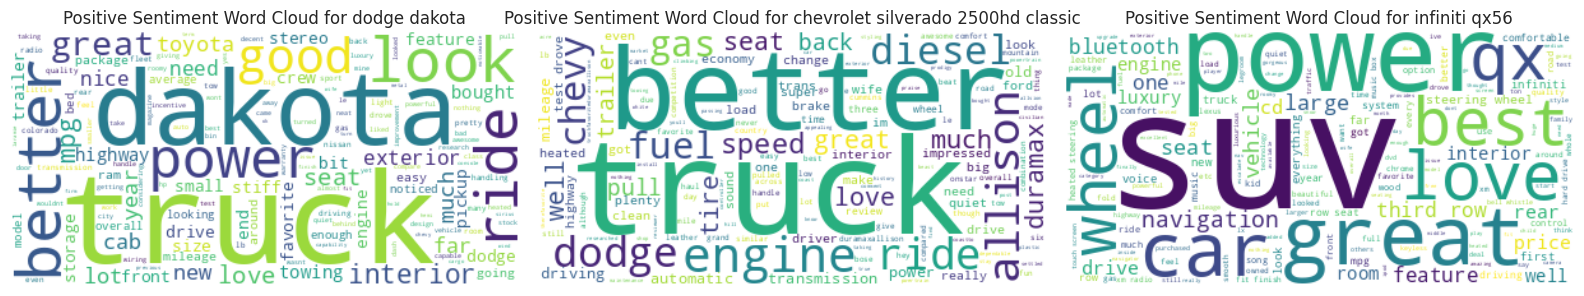

In [ ]:
# Specify the fig size
plt.figure(figsize=(16, 10))

# Iterate over each car
for i, car_name in enumerate(top_cars.index, 1):  # start the subplot index from 1
    # Select comments for the specific car
    comments = cars_df[cars_df['Car_Name'] == car_name]['Processed_Comment'].tolist()

    # Word Cloud for Positive Reviews
    positive_comments = ' '.join([comment for comment in comments if sia.polarity_scores(comment)['compound'] > 0])
    positive_wordcloud = WordCloud(width=400, height=200, background_color='white').generate(positive_comments)

    # Plot Word Clouds on the same row
    plt.subplot(1, len(top_cars), i)  # use a single row of subplots
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title(f'Positive Sentiment Word Cloud for {car_name}')
    plt.axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Top 10 Words Frequency Distribution by car

In [ ]:
# Top 10 Words Frequency Distribution by car
for car_name in top_cars.index:
    # Select comments for the specific car
    comments = cars_df[cars_df['Car_Name'] == car_name]['Processed_Comment'].tolist()

    # Word Cloud for Positive Reviews
    positive_comments = ' '.join([comment for comment in comments if sia.polarity_scores(comment)['compound'] > 0])

    # Calculate FreqDist for positive comments
    positive_tokens = word_tokenize(positive_comments)
    pos_freqdist = FreqDist(positive_tokens)

    # Display the top 10 words using tabulate in the specified format
    top_words_table = [(word, freq) for word, freq in pos_freqdist.most_common(10)]

    # Transpose the list of rows to convert rows to columns
    transposed_table = list(map(list, zip(*top_words_table)))

    # Display the transposed table using tabulate in the specified format
    print(f"Top 10 Words Frequency Distribution for {car_name}")
    print(tabulate(transposed_table, tablefmt='grid'))
    print()

Top 10 Words Frequency Distribution for dodge dakota
+-------+--------+------+--------+------+------+-------+------+-------+----------+
| truck | dakota | look | better | like | ride | power | good | great | interior |
+-------+--------+------+--------+------+------+-------+------+-------+----------+
| 24    | 15     | 14   | 14     | 13   | 12   | 11    | 11   | 10    | 10       |
+-------+--------+------+--------+------+------+-------+------+-------+----------+

Top 10 Words Frequency Distribution for chevrolet silverado 2500hd classic
+-------+--------+--------+---------+------+-------+--------+-------+------+-----+
| truck | better | engine | allison | ride | dodge | diesel | chevy | like | gas |
+-------+--------+--------+---------+------+-------+--------+-------+------+-----+
| 16    | 11     | 10     | 9       | 8    | 8     | 7      | 6     | 6    | 6   |
+-------+--------+--------+---------+------+-------+--------+-------+------+-----+

Top 10 Words Frequency Distribution for 

## Top 20 Words Frequency Distribution in Positive Comments by Car

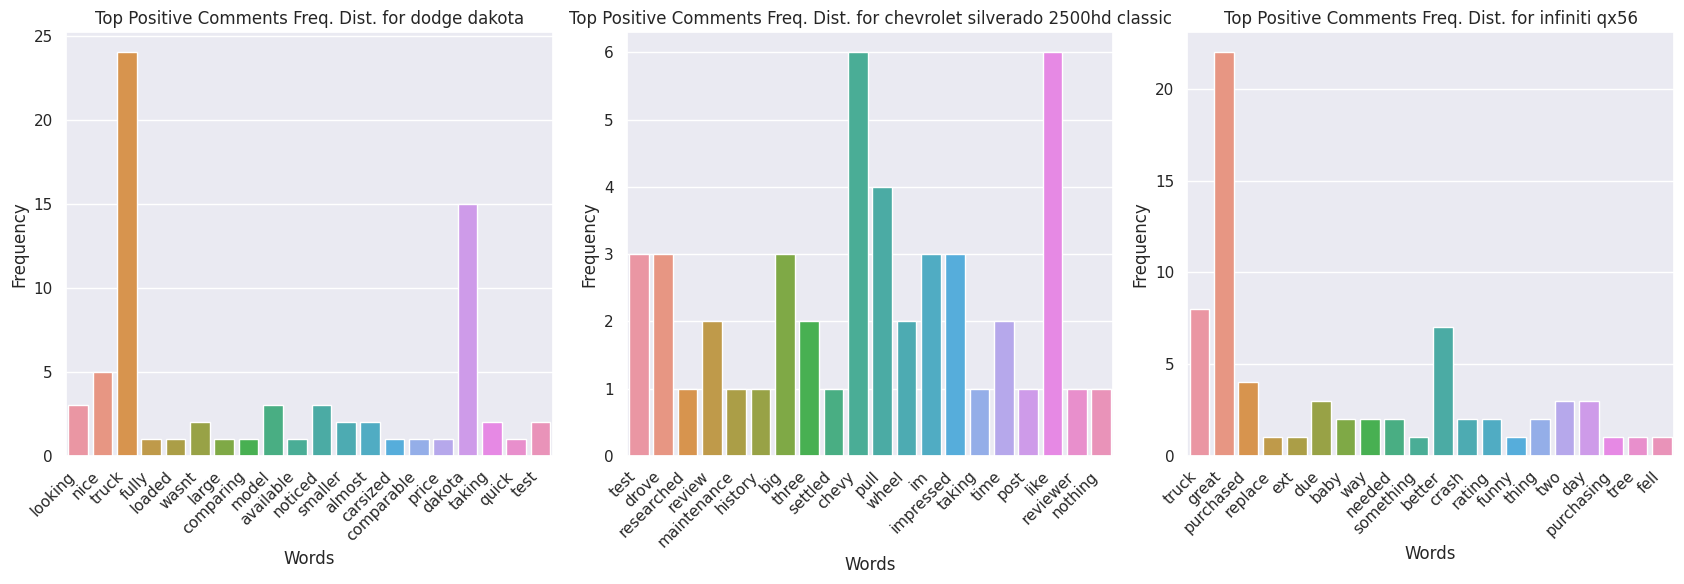

In [ ]:
# Specify the fig size
plt.figure(figsize=(17,6))

# Iterate over each car
for i, car_name in enumerate(top_cars.index, 1):  # start the subplot index from 1
    # Select comments for the specific car
    comments = cars_df[cars_df['Car_Name'] == car_name]['Processed_Comment'].tolist()

    # Word Cloud for Positive Reviews
    positive_comments = ' '.join([comment for comment in comments if sia.polarity_scores(comment)['compound'] > 0])

    # Only proceed if there are positive comments
    if positive_comments:
        # Calculate FreqDist for positive comments
        positive_tokens = word_tokenize(positive_comments)
        pos_freqdist = FreqDist(positive_tokens)

        # Plot bar plots on the same row
        plt.subplot(1, len(top_cars), i)  # use a single row of subplots
        sns.barplot(x=list(pos_freqdist.keys())[:20], y=list(pos_freqdist.values())[:20])
        plt.title(f'Top Positive Comments Freq. Dist. for {car_name}')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


## Topic Modeling for Key Reasons:

In [ ]:
# Convert the proccessed comments to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(cars_df['Processed_Comment'])

# initializing the Latent Dirichlet Allocation (LDA) model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

In [ ]:
# Print top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}: {', '.join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])}")

Topic #1: truck, seat, great, vehicle, love, ride, room, row, suv, power
Topic #2: car, great, love, lexus, drive, navigation, bluetooth, seat, ride, nav
Topic #3: car, great, mpg, seat, good, mileage, gas, drive, like, driving
Topic #4: car, great, drive, look, love, like, fun, interior, handling, performance
Topic #5: car, problem, mile, dealer, time, tire, vehicle, noise, replaced, dealership
